### Visualization: Player performance per match
In this notebook, I will try to evaluate a player's performance depending on aspects of the game related to his position.
<ul>
    <li>Midfielder performances</li>
    <li>Defender performances</li>
    <li>Striker performances</li>
</ul>


#### Imports

In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np

import seaborn as sn 
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
from highlight_text import fig_text

import warnings
warnings.filterwarnings('ignore')

#### Match data extraction


In [2]:
# As extracted earlier; season id is 106, competition id is 43
matches_df= sb.matches(competition_id= 43, season_id= 106)

# Use case match: WC Final
final_id= int(matches_df.loc[matches_df.competition_stage== 'Final'].match_id)

# WC final match data
df= sb.events(match_id= final_id)
df.head()

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,...,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'formation': 433, 'lineup': [{'player': {'id'...",Argentina,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",France,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,France,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Argentina,00:00:00.000,Half Start,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,France,00:00:00.000,Half Start,NaN


### Midfielder performances: Enzo Fernandez

In [3]:
# Add additional information to Statsbomb event data
def add_info(df, filter_by):
    
    # Error handling
    filters= ['Pass', 'Shot', 'Carry', 'Dribble']
    if filter_by not in filters:
        raise ValueError ("Invalid argument. Allowed filters are:", filters)
        
    # Goal coordinates    
    goal_X= 120
    goal_Y= 40
        
    # Filter by event & 
    df= df.loc[df.type== filter_by]
    
    # Add starting location coordinates
    df[['X', 'Y']] = pd.DataFrame(df['location'].to_list(), index= df.index)
    
    # Add end location coordinates
    if filter_by in ['Pass', 'Carry']:
        df[['end_X', 'end_Y']]= pd.DataFrame(df['{}_end_location'.format(filter_by.lower())].to_list(), index= df.index)
        
         # add the distance between starting point and the goal (progressie passes calculation):
        df['start_distance']= np.sqrt((goal_X - df.X)**2 + (goal_Y - df.Y)**2)
        df['end_distance']= np.sqrt((goal_X - df.end_X)**2 + (goal_Y - df.end_Y)**2)
        
         # check if an event is progressive or not
        df['isProgressive'] = ((abs(df['start_distance'] - df['end_distance']) >= 0.25 * df['start_distance']) & (abs(df['Y'] - df['end_Y']) >= 5)).tolist()


    elif filter_by is 'Shot':
        df[['shot_end_X', 'shot_end_Y', 'shot_end_Z']]= pd.DataFrame(df['shot_end_location'].to_list(), index= df.index)
        
    return df

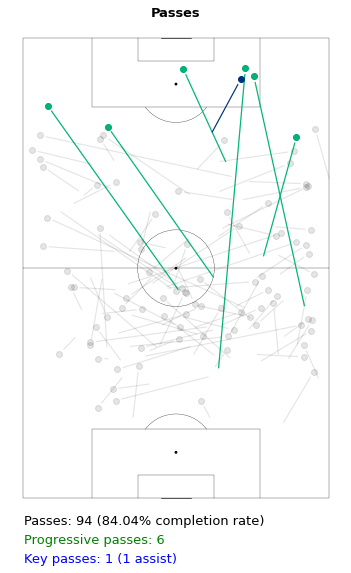

In [4]:
# passes plot 
def plot_passes(df, player_name, pitch, ax):
    

    df= df.loc[df.player== player_name]
    df= add_info(df, 'Pass')

    # set lists
    for i, row in df.iterrows():

        if row['isProgressive']== True:
            pitch.scatter(row['end_X'], row['end_Y'],color="#03C988", ax=ax)
            pitch.arrows(row['X'], row['Y'], row['end_X'], row['end_Y'], color = "#03C988", width=1.2, headwidth= 0, ax=ax)

        if row['pass_shot_assist']== True:
            pitch.scatter(row['end_X'], row['end_Y'],color="#00337C", ax=ax)
            pitch.arrows(row['X'], row['Y'], row['end_X'], row['end_Y'], color = "#00337C", width=1.2, headwidth= 0, ax=ax)

        else:
            pitch.scatter(row['end_X'], row['end_Y'],color="black", alpha= .1, ax=ax)
            pitch.arrows(row['X'], row['Y'], row['end_X'], row['end_Y'], color = "Black", width=1.2, headwidth= 0, alpha=.1, ax=ax)

    completion_rate= (len(df.loc[~df.pass_outcome.isin(['Incomplete', 'Out', 'Unknown'])])/ len(df))*100

    dicts= [
            {'Passes: {} ({}% completion rate)'.format(len(df), round(completion_rate,2)):'black'},

            {'Progressive passes: {}'.format((df['isProgressive'] == True).sum()): 'green'},

            {'Key passes: {} ({} assist)'.format((df['pass_shot_assist']== True).sum(), 
                                                 (df['pass_shot_assist']==True).sum()): 'blue'}]

    y = -0.03

    for dict_ in dicts:
        for expression, color in dict_.items():
            ax.text(x=0.05, y=y, s= expression, fontsize=13, color= color,ha='left', va='top',  transform=ax.transAxes)
            y -= 0.04
            
    ax.set_title(label="Passes", loc='center', fontweight='bold', fontsize= 13)
    
# Set pitch  
pitch = VerticalPitch(pitch_type= 'statsbomb',pad_bottom=0.5, goal_alpha=1,
                      pitch_color= 'white', line_color='black', linewidth=.3) 
fig, ax = pitch.draw(figsize=(8, 8))
fig.set_facecolor('white')
    
# Enzo Fenrandez passes plot
plot_passes(df, "Enzo Fernandez", pitch, ax)

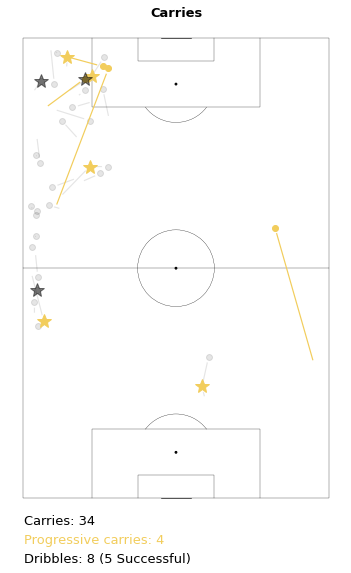

In [5]:
# Carries plot (ball carries, progressive carries, carries into final third, Take-ons )
def plot_carries(df, player_name, pitch, ax):

    df= df.loc[df.player== player_name]

    # Dribbles
    DFD= add_info(df, 'Dribble')
    for i, row in DFD.iterrows():

        if row['dribble_outcome'] == 'Complete'  :
            pitch.plot(row['X'], row['Y'], color="#F2CD5C", marker= '*', markersize= 15, ax=ax)
        elif row['dribble_outcome'] == 'Incomplete':
            pitch.plot(row['X'], row['Y'],color="black", marker= '*', markersize= 15, alpha=.5, ax=ax)

    # Carries
    DFC= add_info(df, 'Carry')
    for i, row in DFC.iterrows():

        if row['isProgressive']== True  :
            pitch.scatter(row['end_X'], row['end_Y'],color="#F2CD5C", ax=ax)
            pitch.arrows(row['X'], row['Y'], row['end_X'], row['end_Y'], color = "#F2CD5C", width=1.2, headwidth= 0, ax=ax)
        else:
            pitch.scatter(row['end_X'], row['end_Y'],color="black", alpha= .1, ax=ax)
            pitch.arrows(row['X'], row['Y'], row['end_X'], row['end_Y'], color = "Black", width=1.2, headwidth= 0, alpha=.1, ax=ax)

    # Legend
    dicts= [
            {'Carries: {} '.format(len(DFC)):'black'},

            {'Progressive carries: {}'.format((DFC['isProgressive'] == True).sum()): '#F2CD5C'},

            {'Dribbles: {} ({} Successful)'.format((DFD['dribble_outcome'].isin(['Incomplete', 'Complete'])).sum(), 
                                                 (DFD['dribble_outcome']== 'Complete').sum()): 'black'}]

    y = -0.03

    for dict_ in dicts:
        for expression, color in dict_.items():
            ax.text(x=0.05, y=y, s= expression, fontsize=13, color= color,ha='left', va='top',  transform=ax.transAxes)
            y -= 0.04

    ax.set_title(label="Carries", loc='center', fontweight='bold', fontsize= 13)

# Set pitch  
pitch = VerticalPitch(pitch_type= 'statsbomb',pad_bottom=0.5, goal_alpha=1,
                      pitch_color= 'white', line_color='black', linewidth=.3) 
fig, ax = pitch.draw(figsize=(8, 8))
fig.set_facecolor('white')
    
# Di Maria plot
plot_carries(df, "Ángel Fabián Di María Hernández", pitch, ax )

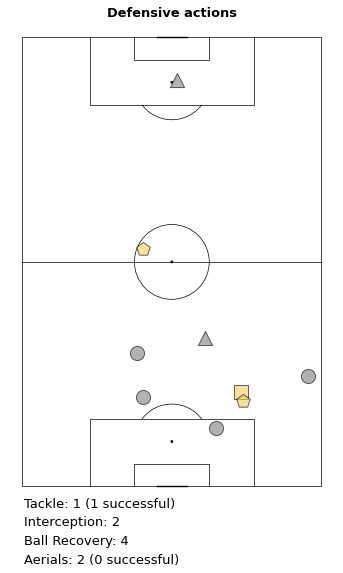

In [6]:
# Defensive Actions (Ball Recovery, Block, Clearance, Interception, )

def plot_def_actions(df, player_name, pitch, ax):
    
    df= df.loc[df.player== player_name]
    df[['X', 'Y']] = pd.DataFrame(df['location'].to_list(), index= df.index)
    df= df.loc[df.type.isin(['Ball Recovery', 'Interception', 'Duel'])]

    colors = []
    markers = []

    for i, row in df.iterrows():
        if row['duel_outcome'] == 'Won' or row['interception_outcome']== 'Won':
            colors.append('#F2CD5C')
        else:
            colors.append('grey')

        if row['type'] == 'Duel':
            if row['duel_type'] == 'Tackle':
                markers.append('s')
            elif row['duel_type'] == 'Aerial Lost':
                markers.append('^')
        elif row['type'] == 'Interception':
            markers.append('p')
        elif row['type'] == 'Ball Recovery':
            markers.append('o')

    for x,y, m, c in zip(df['X'], df['Y'], markers, colors):
        pitch.scatter(x,y, marker=m, c=c, s= 200, ax= ax, edgecolor= 'black', linewidth= 1, alpha=.6) 

    # Add defensive information
    
    tackles= df.loc[(df['type']== 'Duel') & (df['duel_type']== 'Tackle')]
    tackles_won= tackles.loc[df['duel_outcome']== 'Won']
    interceptions= df.loc[df['type']== 'Interception']
    ball_rec= df.loc[df['type']== 'Ball Recovery']
    aerials= df.loc[(df['type']== 'Duel') & (df['duel_type']== 'Aerial Lost')]
    aerials_won= aerials.loc[df['duel_outcome']== 'Won']

    dicts = [
    {'Tackle: {} ({} successful)'.format(len(tackles), len(tackles_won)): 'black'},
    {'Interception: {}'.format(len(interceptions)): 'black'},
    {'Ball Recovery: {}'.format(len(ball_rec)): 'black'},
    {'Aerials: {} ({} successful)'.format(len(aerials), len(aerials_won)): 'black'}
    ]

    y = -0.04

    for dict_ in dicts:
        for expression, color in dict_.items():
            ax.text(0.05, y, expression, size=13, color=color, ha='left', transform=ax.transAxes)
            y -= 0.04
            
    ax.set_title(label="Defensive actions", loc='center', fontweight='bold', fontsize= 13)

    
    
# Set pitch & test plotting 
pitch = VerticalPitch(pitch_type= 'statsbomb',pad_bottom=0.5, goal_alpha=1,
                      pitch_color= 'white', line_color='black', linewidth=.7) 
fig, ax = pitch.draw(figsize=(8, 8))
fig.set_facecolor('white')

plot_def_actions(df, 'Cristian Gabriel Romero', pitch, ax)

Text(0, 0.96, 'Argentina vs France | FIFA World Cup Final 2022')

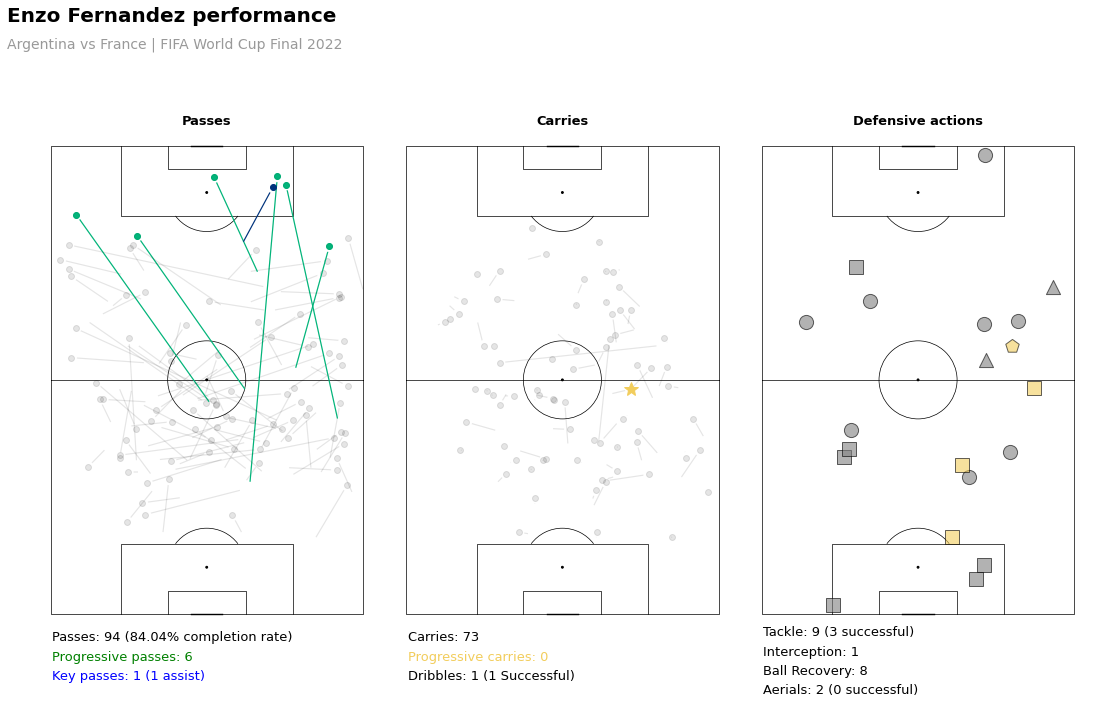

In [22]:
# Put it all together
pitch = VerticalPitch(pitch_type= 'statsbomb',pad_bottom=0.5, goal_alpha=1,
                      pitch_color= 'white', line_color='black', linewidth=.7) 
fig, ax= pitch.grid(ncols= 3, grid_height= .75, space= .05, axis= False)
fig.set_facecolor('white')

# PLotting
plot_passes(df, "Enzo Fernandez", pitch, ax['pitch'][0])
plot_carries(df, "Enzo Fernandez", pitch, ax['pitch'][1])
plot_def_actions(df, 'Enzo Fernandez', pitch, ax['pitch'][2])

# Set titles & legend
title= "Enzo Fernandez performance"
subtitle= "Argentina vs France | FIFA World Cup Final 2022"
fig.text(0, 1, title, fontsize=20, fontweight= 'bold', color='black')
fig.text(0, .96, subtitle, fontsize=14, color='black',alpha=.4)